In [1]:
# Create venv to fix import / dependency issues
!activate mldevenvver3-9-19

In [2]:
# %pip install tensorflow

In [3]:
# Whether to use generated only or a combination of MNIST and generated images
use_generated_only = True

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models

import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import random
import matplotlib.pyplot as plt

In [5]:
def load_generated_images(folder):
    images = []
    labels = []
    for filename in tqdm(os.listdir(os.path.abspath(folder)), desc='Loading generated images...'):
        img = Image.open(os.path.join(folder, filename))
        img = np.array(img)
        label = int(filename.split('_')[2])  # Extract label from filename
        if img.shape != (28,28):
            print(f"File: {filename}, Shape: {img.shape}, Label: {label}")
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load your generated images
generated_images, generated_labels = load_generated_images('C:/Users/conno/OneDrive/Desktop/Repos/opencv-sudoku-solver/classificationModel/trainingImages')
# Ensure the generated images have the same shape as the MNIST images
generated_images = generated_images.reshape(-1, 28, 28)

Loading generated images...: 100%|████████████████████████████████████████████| 213750/213750 [24:06<00:00, 147.76it/s]


In [6]:
from sklearn.model_selection import train_test_split

if use_generated_only:
    # Split generated and use only that as dataset
    X_train, X_test, y_train, y_test = train_test_split(generated_images, generated_labels, test_size=0.2)
else:
    # Load dataset and split into test and train -> X = input (images), y = output (labels, i.e. "7")
    mnist = tf.keras.datasets.mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # Combine generated with MNIST
    X_train = np.concatenate((X_train, generated_images), axis=0)
    y_train = np.concatenate((y_train, generated_labels), axis=0)

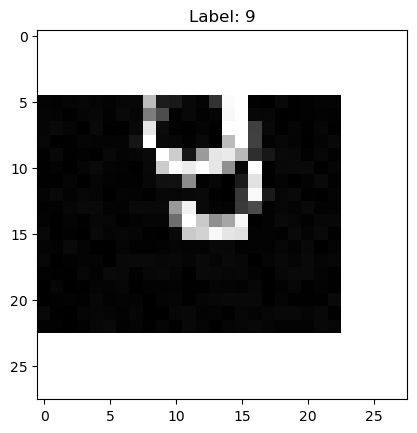

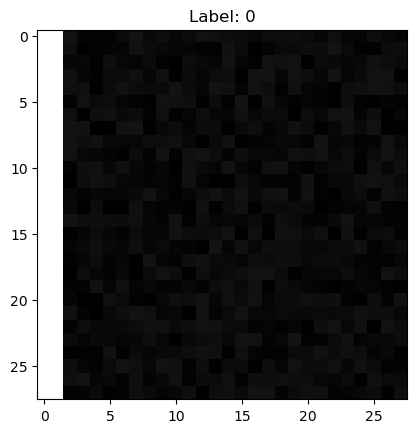

In [7]:
# Normalize the images grayscale from 0-255 to 0-1 scale
X_train, X_test = X_train/255.0, X_test/255.0

# random image
index = random.randint(0, 100)

plt.imshow(X_train[index], cmap='gray')  # MNIST images are grayscale
plt.title(f'Label: {y_train[index]}')
plt.show()

# random image
index = random.randint(0, 100)

plt.imshow(generated_images[index], cmap='gray')  # MNIST images are grayscale
plt.title(f'Label: {generated_labels[index]}')
plt.show()

# Reshape images to fit the CNN input requirements
X_train = X_train.reshape(-1, 28, 28, 1)      # num of images in X_train, 28x28 pixels, 1 colour channel (grayscale)
X_test = X_test.reshape(-1, 28, 28, 1)        # num of images in X_test,  28x28 pixels, 1 colour channel (grayscale)

In [8]:
# Define the CNN model
model = models.Sequential([
    layers.InputLayer(shape=(28, 28, 1)), # Match reshaped pictures
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.Flatten(),
    layers.Dropout(0.2), # Minimizes overfitting by randomly dropping neurons
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(), # Accelerates training (Enables higher learning rates) without increasing risk of overtraining
    layers.Dense(10, activation='softmax') # 10 output neurons for 10 possible outputs (0 - 9)
])

In [9]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Set up early stopping callback to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.8867 - loss: 0.3366 - val_accuracy: 0.9905 - val_loss: 0.0284
Epoch 2/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9930 - loss: 0.0217 - val_accuracy: 0.9962 - val_loss: 0.0122
Epoch 3/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9956 - loss: 0.0133 - val_accuracy: 0.9983 - val_loss: 0.0061
Epoch 4/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9968 - loss: 0.0101 - val_accuracy: 0.9954 - val_loss: 0.0157
Epoch 5/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9975 - loss: 0.0080 - val_accuracy: 0.9967 - val_loss: 0.0102
Epoch 6/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.9979 - loss: 0.0065 - val_accuracy: 0.9983 - val_loss: 0.0058
Epoch 7/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9986 - val_loss: 0.0046
Epoch 8/15
5344/5344 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9985 - loss: 0

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f'Test accuracy: {round(test_acc*100,2)}%, Test loss: {round(test_loss*100,2)}%')

Test accuracy: 99.91%, Test loss: 0.3%


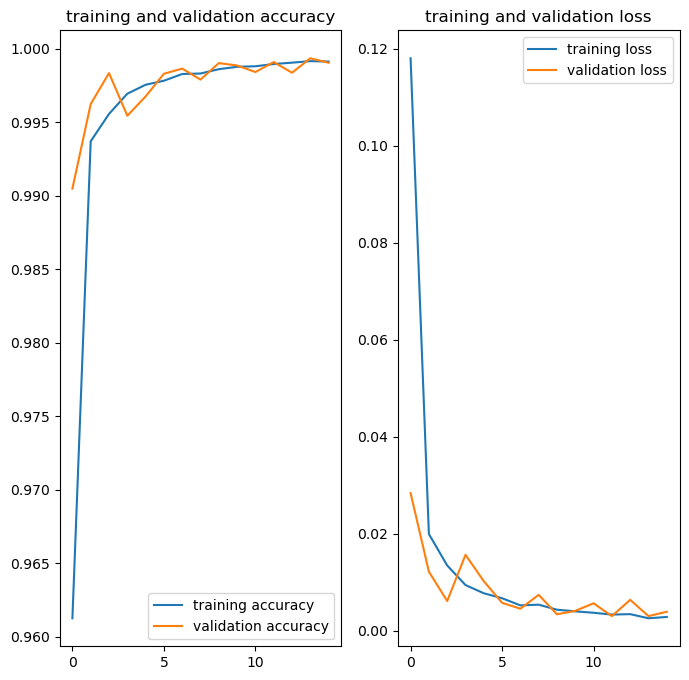

In [12]:
# Visually validate model
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(0, len(acc))
# ymax = max(val_acc)
# xpos = val_acc.index(ymax)
# xmax = epochs_range[xpos]

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='training accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
# plt.annotate('*', xy=(xmax, ymax))
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='training loss')
plt.plot(epochs_range, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')
plt.show()

In [13]:
# Save trained model for easy use later -> Current saved model (MNIST only) had 99.40% test_acc, 2.31% test_loss
# With MNIST + 6168 generated images -> ~99.41
# With only 22320 generated images -> 100% accuracy and 0% loss

model.save('generated_digit_classification_model.keras')